# Setup

## Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import src.bayesian_stats as bst
import os
import pandas as pd
import arviz as az
import pymc as pm
from scipy import stats
from scipy.stats import t
from scipy.stats import norm

print(f"Running on PyMC v{pm.__version__}")

# Set colors for plotting
rpe_color = '#c51b7d'
te_color = '#276419'
plt.rcParams.update({'font.size': 18})

Running on PyMC v4.3.0


## Define Functions

In [4]:
def robust_bayesian_mixed_model_anova(between_subj_var, within_subj_var, subj_id, y, n_samples=1000):
    """Performs Bayesian analogue of mixed model (split-plot) ANOVA.
    
    Models instance of outcome resulting from both between- and within-subjects
    factors. Outcome is measured several times from each observational unit (i.e.,
    repeated measures). 
    
    Args:
        between_subj_var: The between-subjects variable.
        withing_subj_var: The within-subjects variable.
        subj_id: The subj ID variable. 
        y: The outcome variable. 
    
    Returns: 
        PyMC Model and InferenceData objects. 
    """
    # Statistical model: Split-plot design after Kruschke Ch. 20
    # Between-subjects factor (i.e., group)
    x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(between_subj_var)
  
    # Within-subjects factor (i.e., target set)
    x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(within_subj_var)

    # Individual subjects
    x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(subj_id)

    # Dependent variable 
    mu_y = y.mean()
    sigma_y = y.std()

    a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)

    with pm.Model(coords={
        "between_subj": levels_x_between, 
        "within_subj": levels_x_within,
        "subj": levels_x_subj}
        ) as model:

        # Baseline value
        a0 = pm.Normal('a0', mu=mu_y, sigma=sigma_y * 5)

        # Deflection from baseline for between subjects factor
        sigma_B = pm.Gamma('sigma_B', a_shape, a_rate)
        aB = pm.Normal('aB', mu=0.0, sigma=sigma_B, dims="between_subj")

        # Deflection from baseline for within subjects factor
        sigma_W = pm.Gamma('sigma_W', a_shape, a_rate)
        aW = pm.Normal('aW', mu=0.0, sigma=sigma_W, dims="within_subj")

        # Deflection from baseline for combination of between and within subjects factors
        sigma_BxW = pm.Gamma('sigma_BxW', a_shape, a_rate)
        aBxW = pm.Normal('aBxW', mu=0.0, sigma=sigma_BxW, dims=("between_subj", "within_subj"))

        # Deflection from baseline for individual subjects
        sigma_S = pm.Gamma('sigma_S', a_shape, a_rate)
        aS = pm.Normal('aS', mu=0.0, sigma=sigma_S, dims="subj")

        mu = a0 + aB[x_between] + aW[x_within] + aBxW[x_between, x_within] + aS[x_subj] 
        
        #Assumes same variance
        # sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10)
        #Assumes different variances 
        sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10, dims=("between_subj", "within_subj"))

        #Prior on nu parameter
        nu_minus1 = pm.Exponential('nu_minus1', 1 / 29)
        nu = pm.Deterministic('nu', nu_minus1 + 1)     
        
        # Define likelihood 
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma[x_between, x_within], observed=y)
        # likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma_y, observed=y)
        
        # Sample from the posterior
        idata = pm.sample(draws=n_samples, tune=2000, target_accept=0.95)
    
    return model, idata

In [109]:
def plot_post_predictive_ttest(data, group, post, n_samps=20):
    
    grp_names = np.unique(group)
    var_name = data.name
    # Set colors for plotting

    grp_colors = ['#c51b7d', '#276419']
    
    x = np.linspace(np.min(post.group_mean)-np.max(post.group_std),np.max(post.group_mean)+np.max(post.group_std))
    rand_idx = np.random.choice(len(post.group_mean[0,:]), n_samps)

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].hist(data[group==grp_names[0]], bins=10, density=True, alpha=0.5, color=grp_colors[0])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[0,i], scale=post.group_std[0,i])
        ax[0].plot(x, y, c=grp_colors[0], alpha=0.2)
    ax[0].set(title=grp_names[0]+' group', ylabel='probability', xlabel=var_name)

    ax[1].hist(data[group==grp_names[1]],bins=10, density=True, alpha=0.5, color=grp_colors[1])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[1,i], scale=post.group_std[1,i])
        ax[1].plot(x, y, c=grp_colors[1], alpha=0.2)
    ax[1].set(title=grp_names[1]+' group', xlabel=var_name)
    
    plt.show()

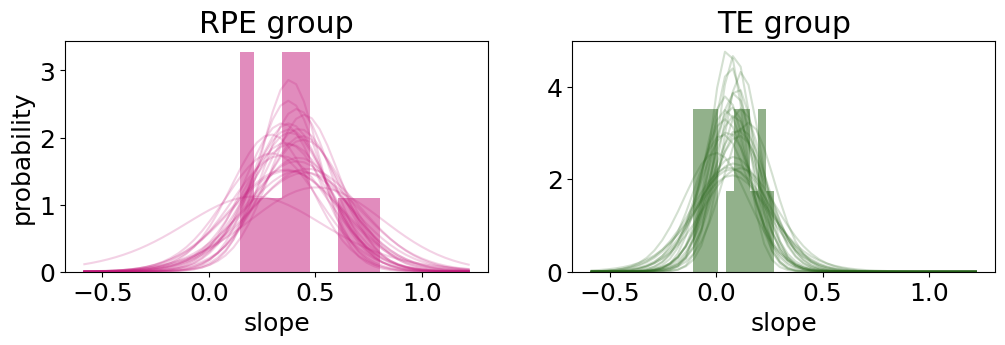

<xarray.Dataset>
Dimensions:              (group_mean_dim_0: 2, sample: 4000, group_std_dim_0: 2)
Coordinates:
  * group_mean_dim_0     (group_mean_dim_0) int64 0 1
  * group_std_dim_0      (group_std_dim_0) int64 0 1
  * sample               (sample) object MultiIndex
  * chain                (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
  * draw                 (sample) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
Data variables:
    group_mean           (group_mean_dim_0, sample) float64 0.3761 ... 0.05419
    group_std            (group_std_dim_0, sample) float64 0.1985 ... 0.1147
    nu_minus_one         (sample) float64 37.35 15.19 14.59 ... 53.16 23.74
    nu                   (sample) float64 38.35 16.19 15.59 ... 54.16 24.74
    nu_log10             (sample) float64 1.584 1.209 1.193 ... 1.734 1.393
    difference of means  (sample) float64 0.3131 0.2648 0.284 ... 0.3187 0.3324
    difference of stds   (sample) float64 0.1157 0.1111 ... 0.01293 0.06427
    effect siz

In [108]:
plot_post_predictive_ttest(df1_var.slope[df1_var.time=="Early"], df1_var.group[df1_var.time=="Early"], post_slope_e1, n_samps=25)

In [6]:
def plot_mustache(mu, sigma, nu, plot_pos, width, color, ax=None):
    for m, s, n in zip(mu, sigma, nu):

        rv = t(df=n, loc=m, scale=s)
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        xrange_scaled = xrange*(width/xrange.max())
        ax.plot(-xrange_scaled+plot_pos, yrange, color=color, alpha=.2)

In [7]:
def plot_posterior_predictive_anova(df, y_str, post, n_mustaches):
    
    #Index group names
    group_names = np.unique(df['group'])
    time_names = np.unique(df['time'])
    
    #For indexing posterior
    burn_in = post.tuning_steps
    all_post_idx = np.arange(len(post.sample))
    post_idx = np.random.randint(burn_in+1, all_post_idx[-1], n_mustaches)

    #Plot prep
    group_colors = ['#c51b7d', '#276419']
    x_offset = [-0.15, 0.15]
    
    #Initilize plot
    fig, ax = plt.subplots(figsize=(10,5),tight_layout=True)
    ax.plot(np.arange(4), np.zeros(4), 'k')
    
    for t_idx, t in enumerate(time_names):
        for g_idx, g in enumerate(group_names):
            
            #Index and plot emperical data
            y_emp = df[y_str][df.time==t][df.group==g]
            x = norm.rvs(1+t_idx+x_offset[g_idx],0.005,len(y_emp))
            ax.plot(x, y_emp, 'o', c=group_colors[g_idx], mec='w', alpha=0.5)
            
            #Index and plot posterior data
            plot_mustache(mu=post.b0.values[post_idx]+
                          post.bB.sel(group=g).values[post_idx]+
                          post.bW.sel(time=t).values[post_idx]+
                          post.bBxW.sel(group=g,time=t).values[post_idx], 
                          sigma=post.sigma.sel(group=g,time=t).values[post_idx], 
                          nu=post.nu.values[post_idx], 
                          plot_pos=0.95+t_idx+x_offset[g_idx], 
                          width=0.15, 
                          color=group_colors[g_idx], ax=ax)
            
    ax.set(xlim=(0.5,2.5), xticks=[1,2], xticklabels=['Early', 'Late'], ylabel=y_str, title='Posterior Predictive Check (' + y_str + ')')
    plt.show()

In [39]:
def plot_contrasts(post, round_to):

    #Index contrasts
    rpe_early = post.b0 + post.bB.sel(group='RPE') + post.bW.sel(time='Early') + post.bBxW.sel(group='RPE',time='Early')
    te_early = post.b0 + post.bB.sel(group='TE') + post.bW.sel(time='Early') + post.bBxW.sel(group='TE',time='Early')
    rpe_late = post.b0 + post.bB.sel(group='RPE') + post.bW.sel(time='Late') + post.bBxW.sel(group='RPE',time='Late')
    te_late = post.b0 + post.bB.sel(group='TE') + post.bW.sel(time='Late') + post.bBxW.sel(group='TE',time='Late')


    contrasts = {"Early vs Late @ RPE": rpe_early - rpe_late,
                 "Early vs Late @ TE": te_early - te_late,
                 "RPE vs TE @ Early Learning": rpe_early - te_early, 
                 "RPE vs TE @ Late Learning": rpe_late - te_late}
    az.plot_posterior(contrasts, 
                      kind="hist",
                      combine_dims={"sample"},
                      bins=50,
                      point_estimate="mean", 
                      ref_val=0,
                      round_to=round_to,
                      hdi_prob=0.95);

    #Caluclate HDIs
    rpe_early_hdi = az.hdi(rpe_early.values, hdi_prob=0.95)
    te_early_hdi = az.hdi(te_early.values, hdi_prob=0.95)
    rpe_late_hdi = az.hdi(rpe_late.values, hdi_prob=0.95)
    te_late_hdi = az.hdi(te_late.values, hdi_prob=0.95)

    #Print values
    print('RPE during Early learning =', np.round(np.mean(rpe_early.values),round_to), np.round(rpe_early_hdi,round_to))
    print('TE during Early learning =', np.round(np.mean(te_early.values),round_to), np.round(te_early_hdi,round_to))
    print('RPE during Late learning =', np.round(np.mean(rpe_late.values),round_to), np.round(rpe_late_hdi,round_to))
    print('TE during Late learning =', np.round(np.mean(te_late.values),round_to), np.round(te_late_hdi,round_to))

In [57]:
def plot_post_simple_comparison(idata, round_to):

    az.plot_posterior(
        idata,
        var_names=["difference of means", "difference of stds", "effect size"],
        ref_val=0,
        color="#87ceeb",
        kind="hist",
        round_to=round_to,
        bins=50,
        hdi_prob=0.95,
    );
    
    summary = az.summary(idata,hdi_prob=0.95)

    print('RPE mean =', round(summary['mean'][0],round_to), '[', round(summary['hdi_2.5%'][0],round_to), round(summary['hdi_97.5%'][0],round_to), ']')
    print('TE mean =', round(summary['mean'][1],round_to), '[', round(summary['hdi_2.5%'][1],round_to), round(summary['hdi_97.5%'][1],round_to), ']')
    print('Difference of means =', round(summary['mean'][7],round_to), '[', round(summary['hdi_2.5%'][7],round_to), round(summary['hdi_97.5%'][7],round_to), ']')

## Load the data

In [87]:
#Change the directory
os.chdir('/Users/jonathanwood/Documents/GitHub/Reinforcement-learning-in-locomotion/Data')

df = pd.read_csv('variability_anova.txt')
df1_var = df[df.experiment==1]
df2_var = df[df.experiment==2]

df2 = pd.read_csv('trial_history_regress.txt')
df1_hist = df2[df2.experiment==1]
df2_hist = df2[df2.experiment==2]

# Experiment 1

## Baseline variability

In [49]:
#Run the model
model_bslvar_e1, idata_bslvar_e1 = bst.BEST(df1_var.bsl_var[df1_var.time=="Early"], df1_var.group[df1_var.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


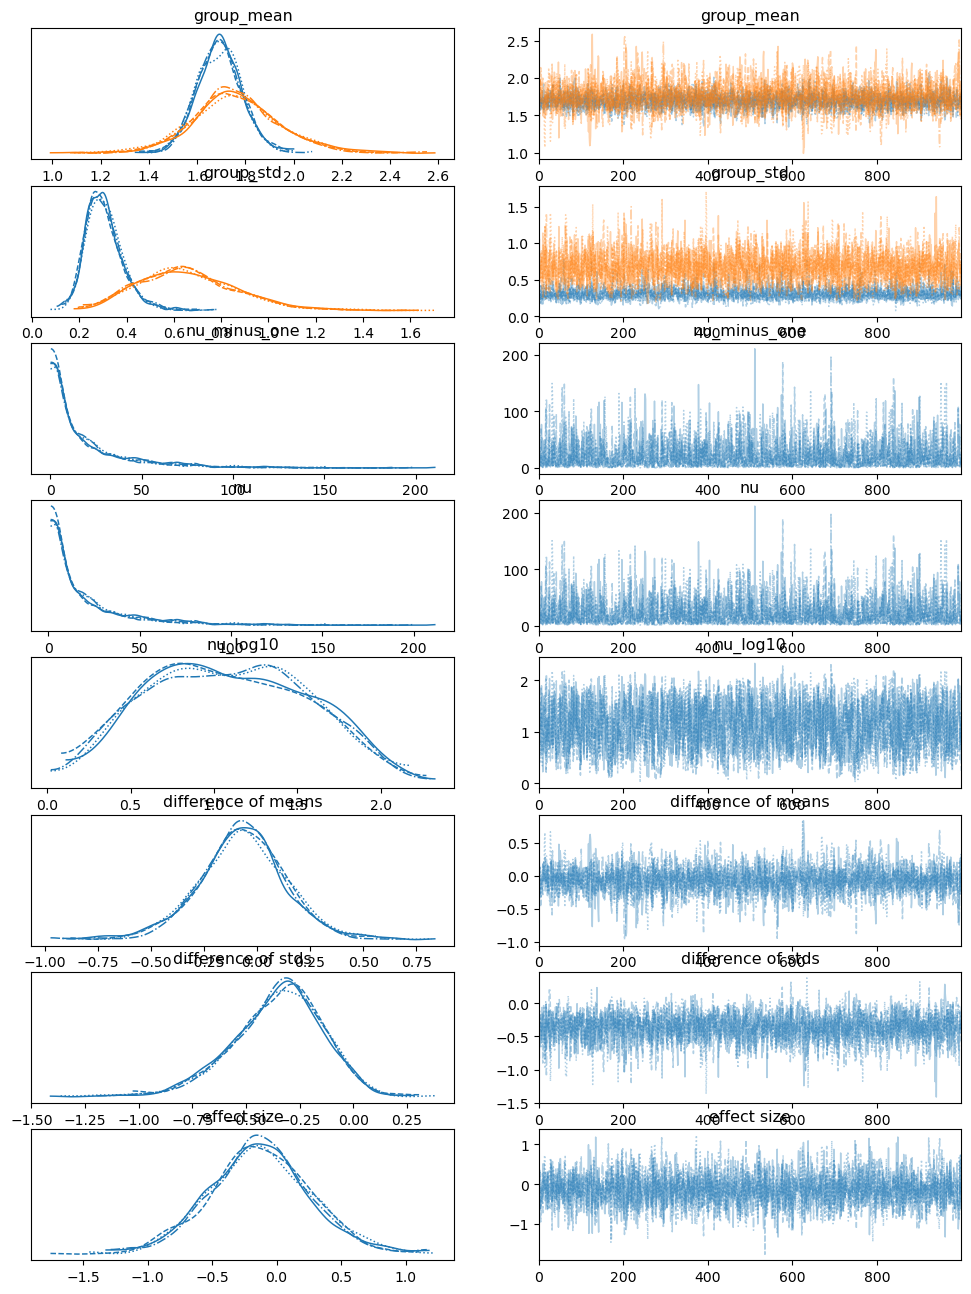

In [50]:
az.plot_trace(idata_bslvar_e1);

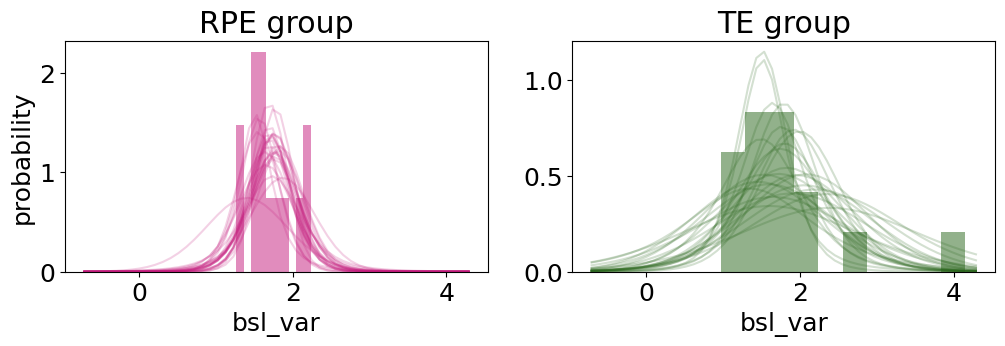

In [51]:
post_bslvar_e1 = az.extract(idata_bslvar_e1)
plot_post_predictive_ttest(df1_var.bsl_var[df1.time=="Early"], df1.group[df1.time=="Early"], post_bslvar_e1, n_samps=25)

RPE mean = 1.69 [ 1.51 1.88 ]
TE mean = 1.76 [ 1.39 2.14 ]
Difference of means = -0.07 [ -0.5 0.33 ]


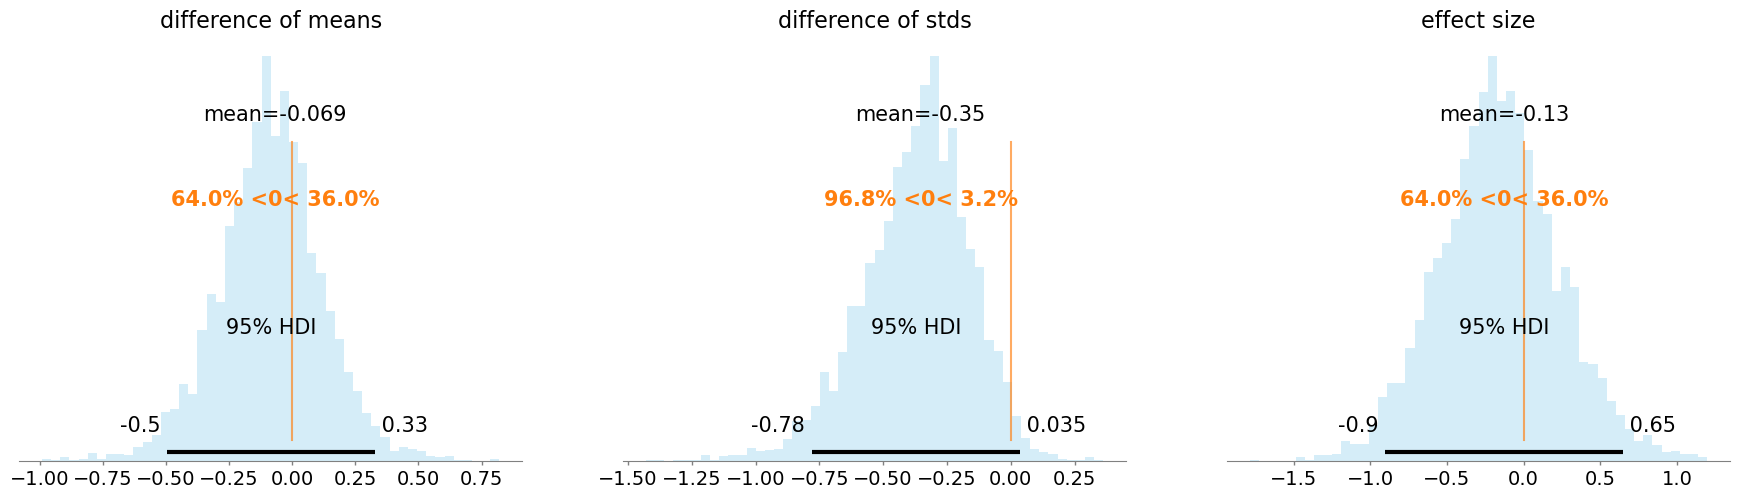

In [56]:
plot_post_simple_comparison(idata_bslvar_e1, round_to=2)

## Learning variability

In [62]:
model_var_e1, idata_var_e1 = robust_bayesian_mixed_model_anova(df1_var.group, df1_var.time, df1_var.subj_id, df1_var.variability, n_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 782 seconds.


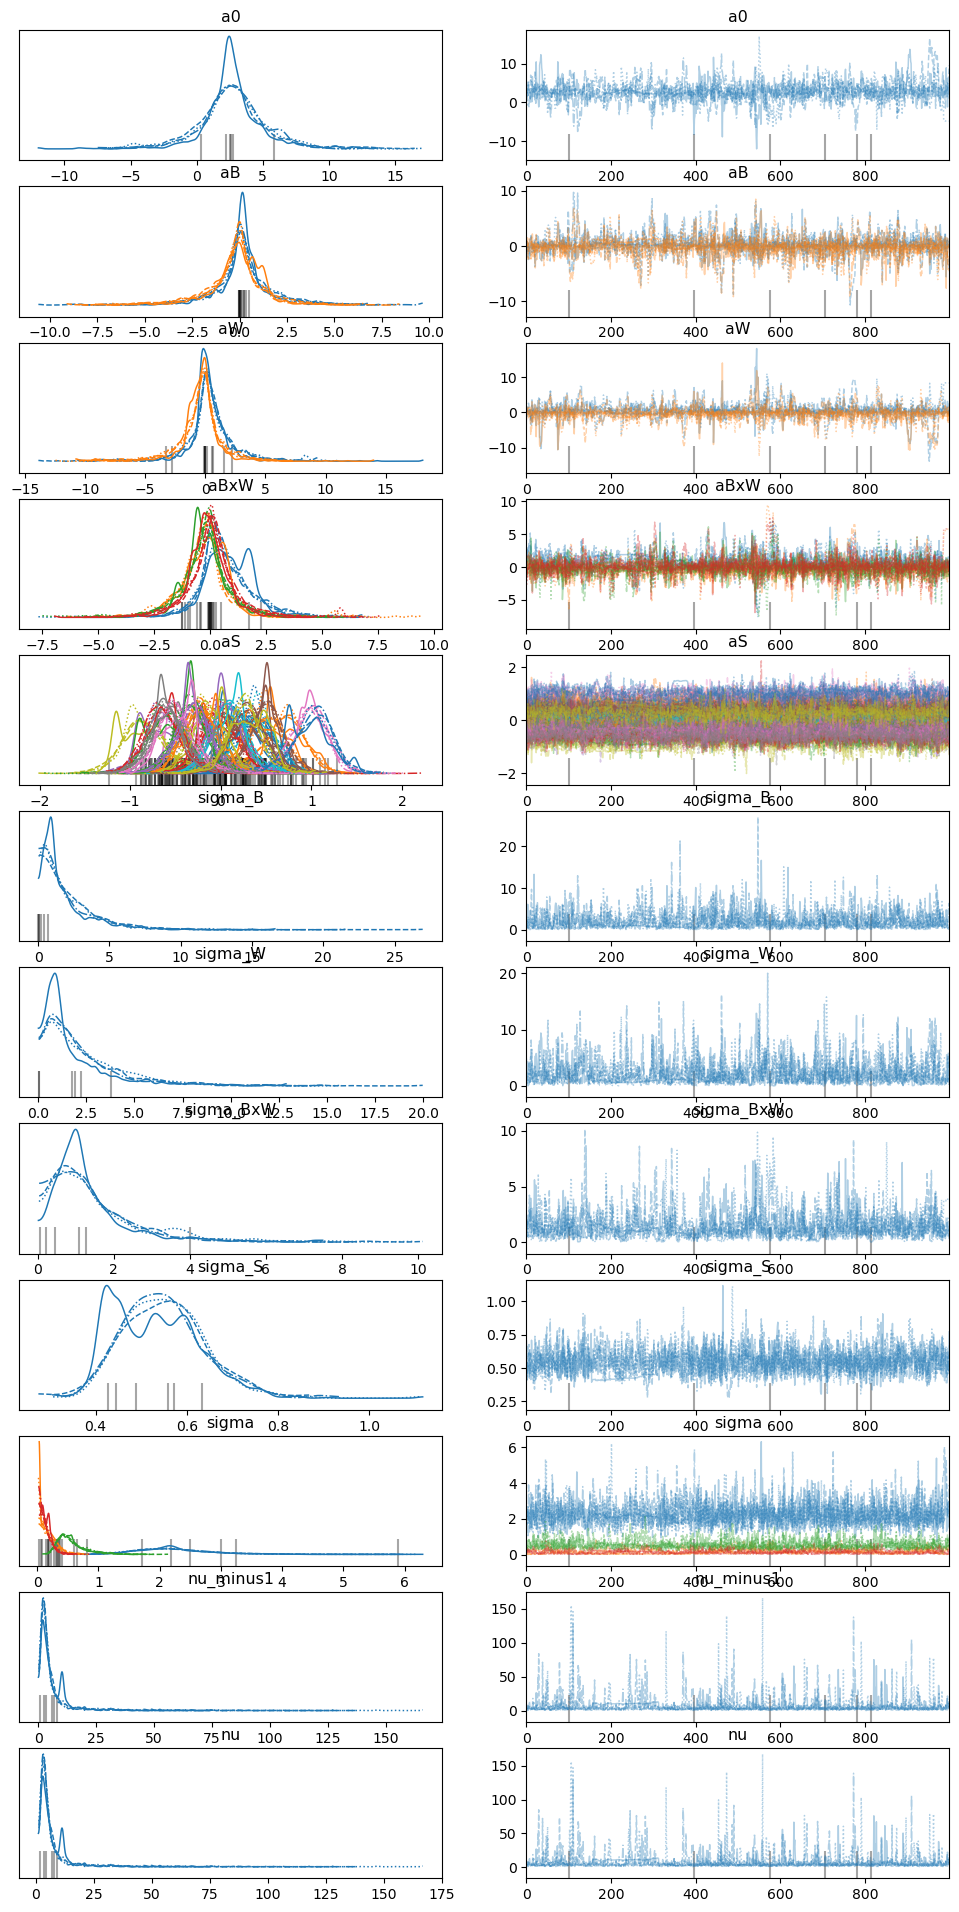

In [63]:
az.plot_trace(idata_var_e1);

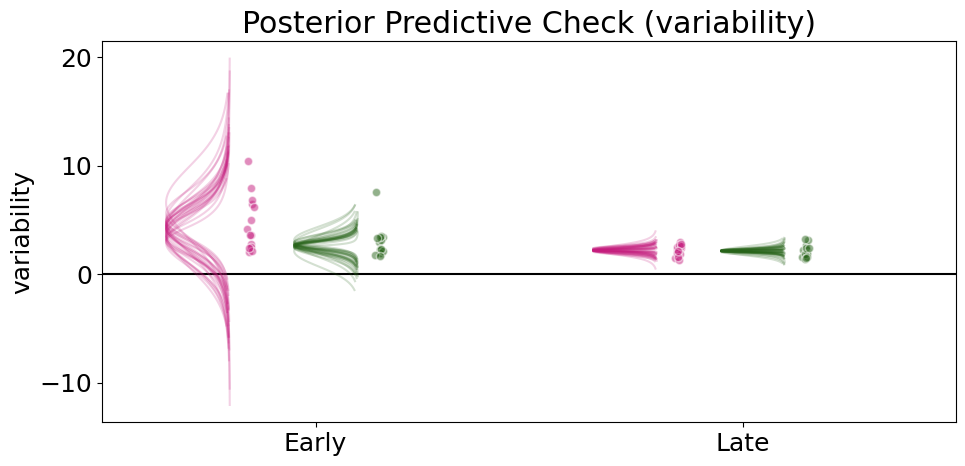

In [64]:
# Convert coefficients to sum-to-zero deflections
post_var_e1 = bst.convert_to_sum_to_zero(idata_var_e1, df1_var.group, df1_var.time, df1_var.subj_id)
# Rename the dimensions for easier label-based indexing
post_var_e1 = post_var_e1.rename({"between_subj": "group", "within_subj": "time"})

#Plot 
plot_posterior_predictive_anova(df1_var, 'variability', post_var_e1, 25)

RPE during Early learning = 4.03 [2.6 5.4]
TE during Early learning = 2.71 [2.35 3.06]
RPE during Late learning = 2.21 [2.06 2.35]
TE during Late learning = 2.14 [2.04 2.25]


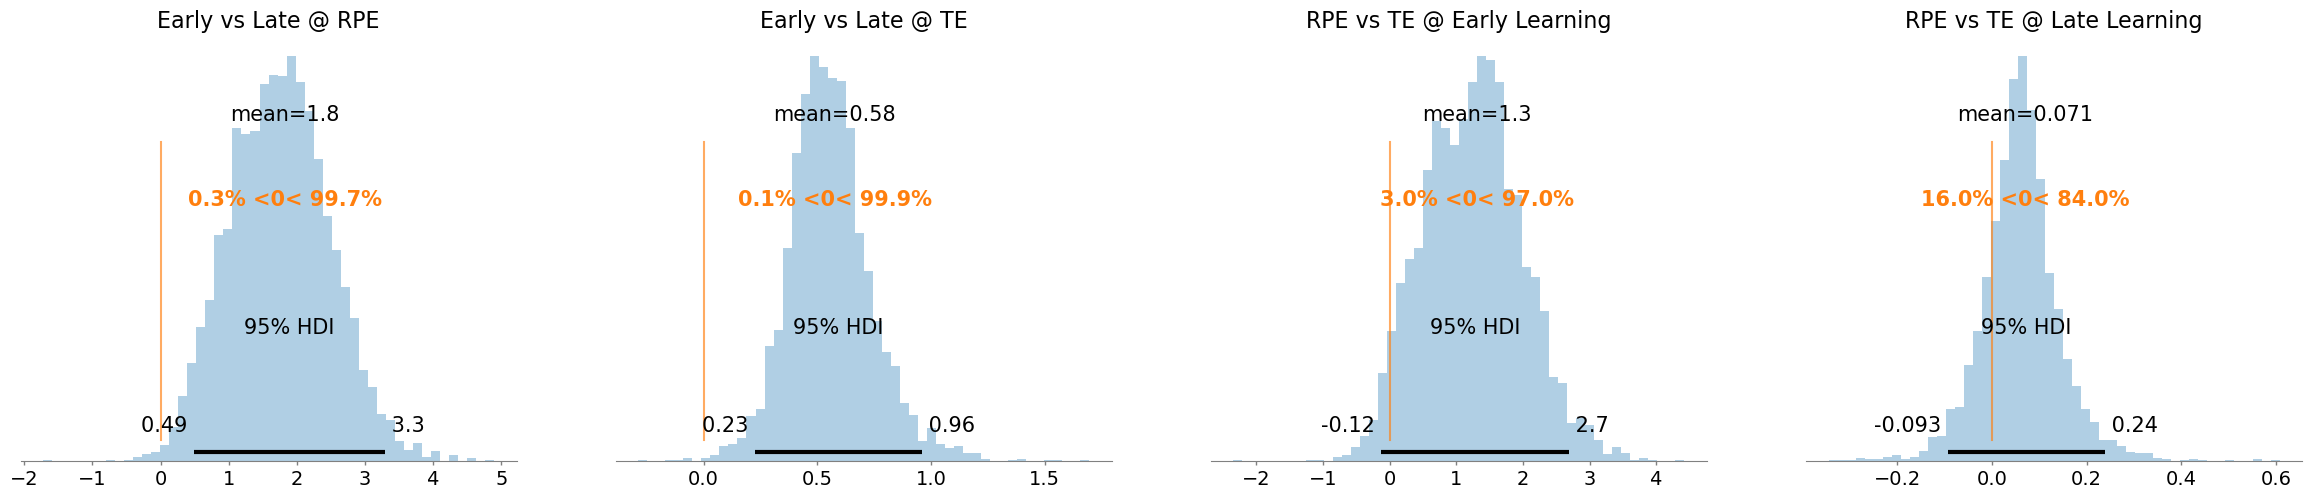

In [67]:
plot_contrasts(post_var_e1, round_to=2)

## Reward history

In [88]:
df1_hist.head()

betas     R_hist      subj_id group  experiment
0  2.253333  Intercept  RewardFB_01   RPE           1
1  1.905649  Intercept  RewardFB_03   RPE           1
2  2.133204  Intercept  RewardFB_06   RPE           1
3  1.335809  Intercept  RewardFB_07   RPE           1
4  1.512238  Intercept  RewardFB_09   RPE           1

In [90]:
model_hist_e1, idata_hist_e1 = robust_bayesian_mixed_model_anova(df1_hist.group, df1_hist.R_hist, df1_hist.subj_id, df1_hist.betas, n_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 574 seconds.


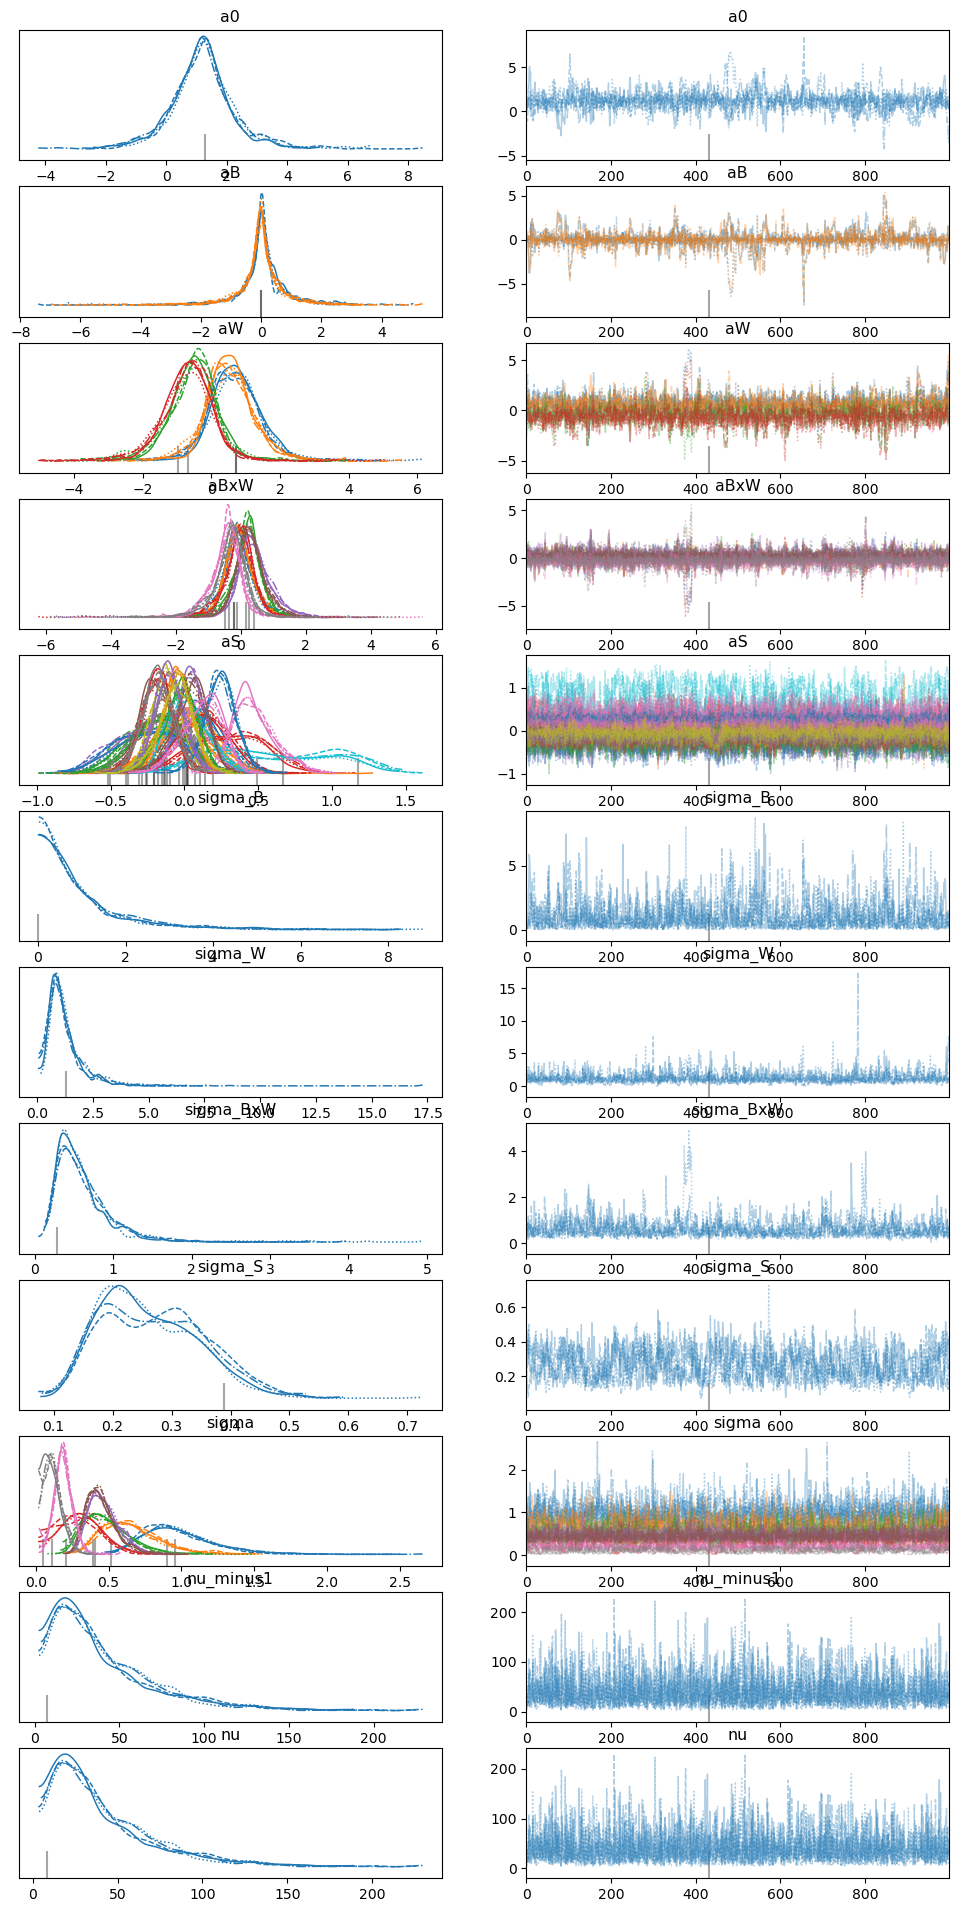

In [91]:
az.plot_trace(idata_hist_e1);

In [92]:
plot_posterior_predictive_anova??

Signature: plot_posterior_predictive_anova(df, y_str, post, n_mustaches)
Docstring: <no docstring>
Source:   
def plot_posterior_predictive_anova(df, y_str, post, n_mustaches):
    
    #Index group names
    group_names = np.unique(df['group'])
    time_names = np.unique(df['time'])
    
    #For indexing posterior
    burn_in = post.tuning_steps
    all_post_idx = np.arange(len(post.sample))
    post_idx = np.random.randint(burn_in+1, all_post_idx[-1], n_mustaches)

    #Plot prep
    group_colors = ['#c51b7d', '#276419']
    x_offset = [-0.15, 0.15]
    
    #Initilize plot
    fig, ax = plt.subplots(figsize=(10,5),tight_layout=True)
    ax.plot(np.arange(4), np.zeros(4), 'k')
    
    for t_idx, t in enumerate(time_names):
        for g_idx, g in enumerate(group_names):
            
            #Index and plot emperical data
            y_emp = df[y_str][df.time==t][df.group==g]
            x = norm.rvs(1+t_idx+x_offset[g_idx],0.005,len(y_emp))
            ax.plot(x, y_emp, 'o', c=

## Correction trend

In [93]:
df1_var.head()

bsl_var  variability     slope      subj_id group   time  experiment
0  2.235839     3.594066  0.413894  RewardFB_01   RPE  Early           1
1  2.082938     7.933128  0.236004  RewardFB_03   RPE  Early           1
2  2.198585     6.505295  0.433865  RewardFB_06   RPE  Early           1
3  1.503220    10.476447  0.368638  RewardFB_07   RPE  Early           1
4  1.571212     2.017318  0.664408  RewardFB_09   RPE  Early           1

In [96]:
#Run the model
model_slope_e1, idata_slope_e1 = bst.BEST(df1_var.slope[df1_var.time=="Early"], df1_var.group[df1_var.time=="Early"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


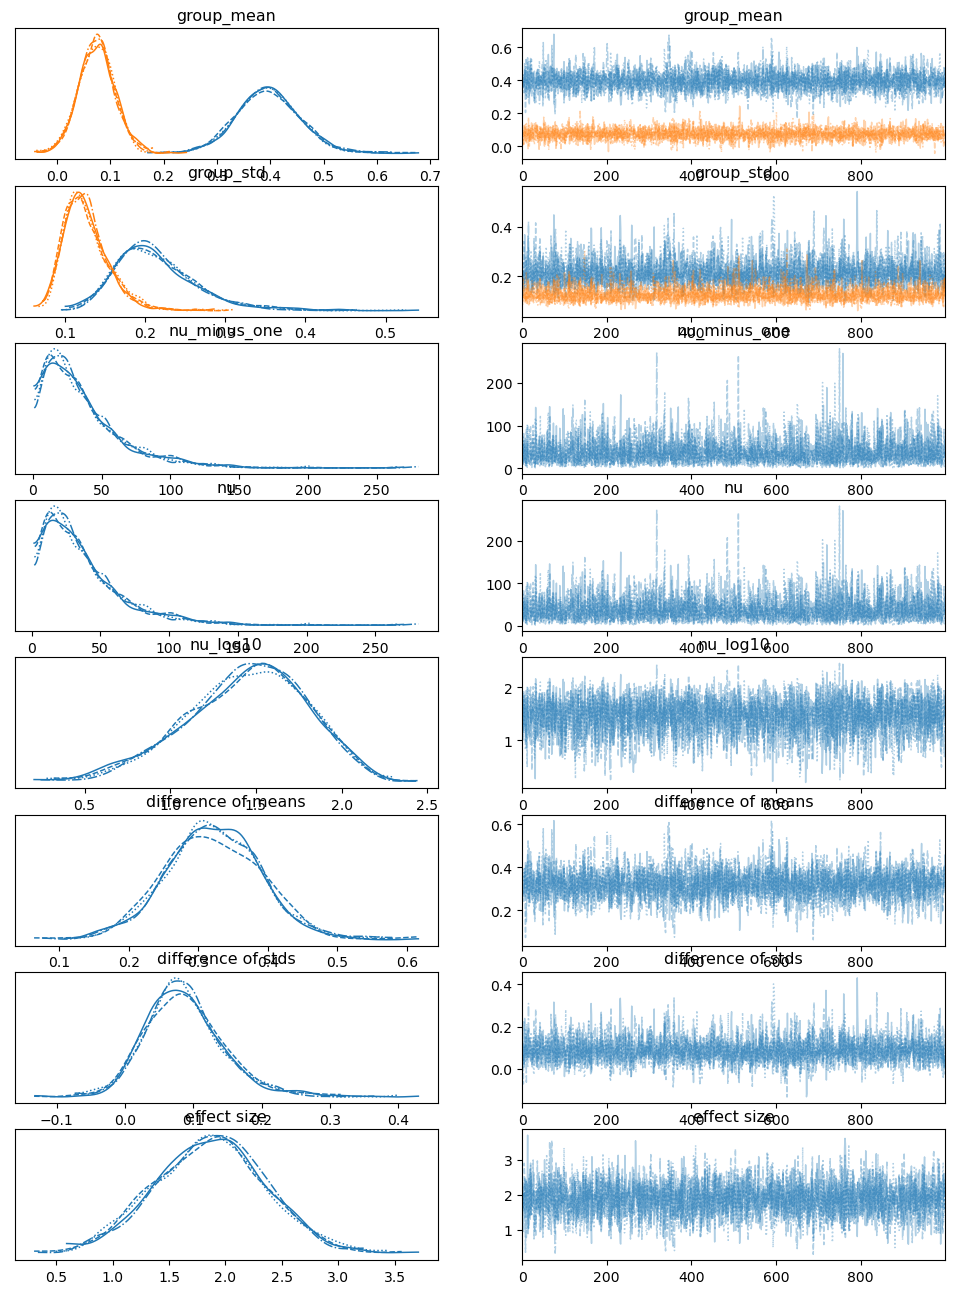

In [97]:
az.plot_trace(idata_slope_e1);

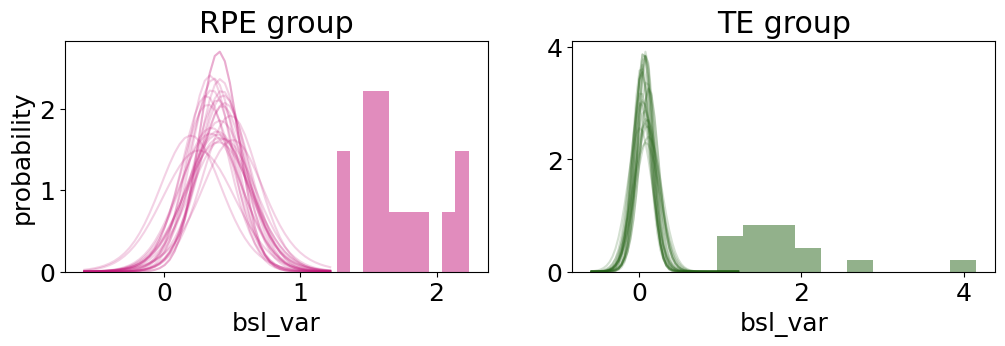

In [102]:
post_slope_e1 = az.extract(idata_slope_e1)
plot_post_predictive_ttest(df1_var.bsl_var[df1_var.time=="Early"], df1_var.group[df1_var.time=="Early"], post_slope_e1, n_samps=25)

# Experiment 2

## Learning variability

In [68]:
model_var_e2, idata_var_e2 = robust_bayesian_mixed_model_anova(df2_var.group, df2_var.time, df2_var.subj_id, df2_var.variability, n_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 425 seconds.


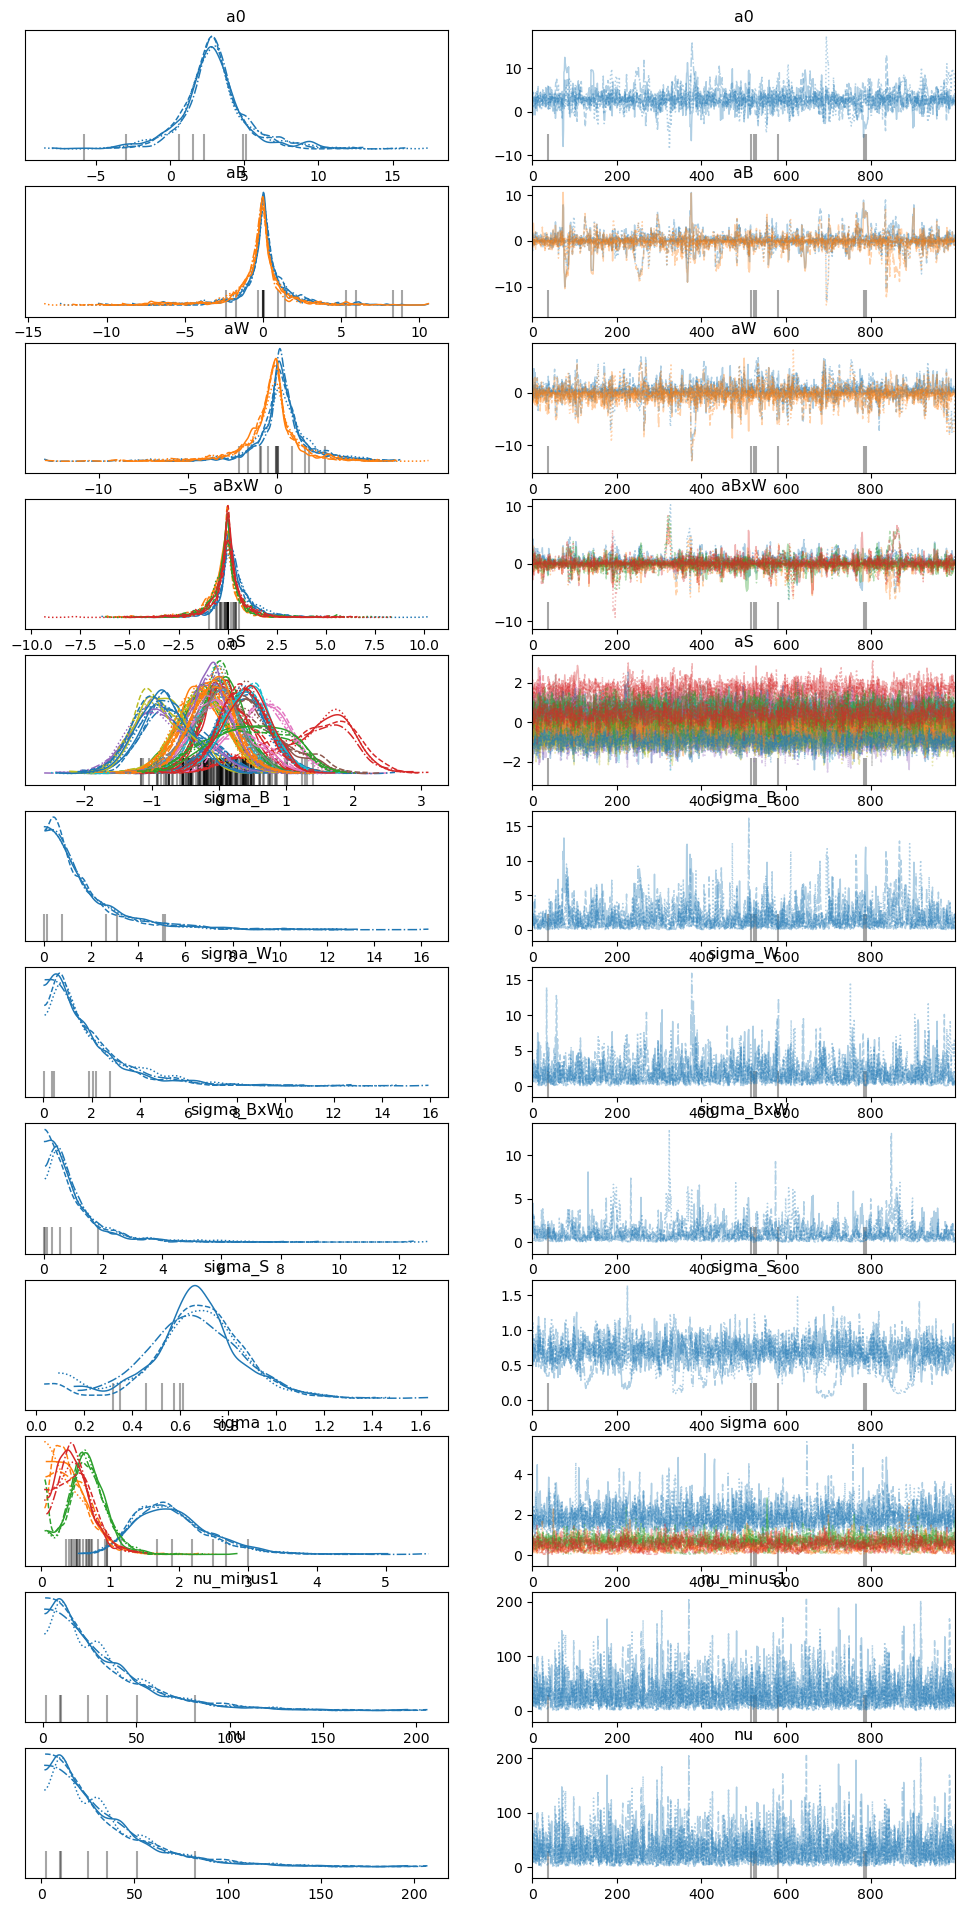

In [69]:
az.plot_trace(idata_var_e2);

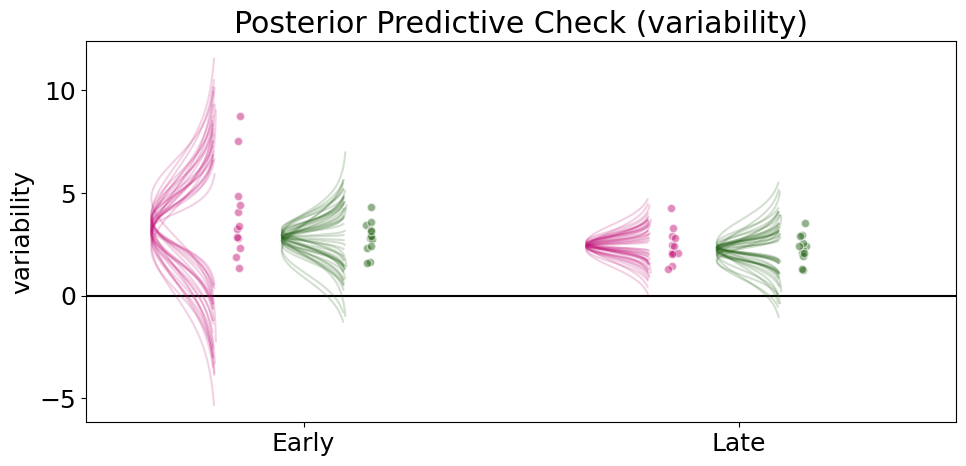

In [70]:
# Convert coefficients to sum-to-zero deflections
post_var_e2 = bst.convert_to_sum_to_zero(idata_var_e2, df2_var.group, df2_var.time, df2_var.subj_id)
# Rename the dimensions for easier label-based indexing
post_var_e2 = post_var_e2.rename({"between_subj": "group", "within_subj": "time"})

#Plot 
plot_posterior_predictive_anova(df2_var, 'variability', post_var_e2, 25)

RPE during Early learning = 3.58 [2.51 4.72]
TE during Early learning = 2.86 [2.44 3.33]
RPE during Late learning = 2.45 [2.15 2.8 ]
TE during Late learning = 2.29 [1.94 2.62]


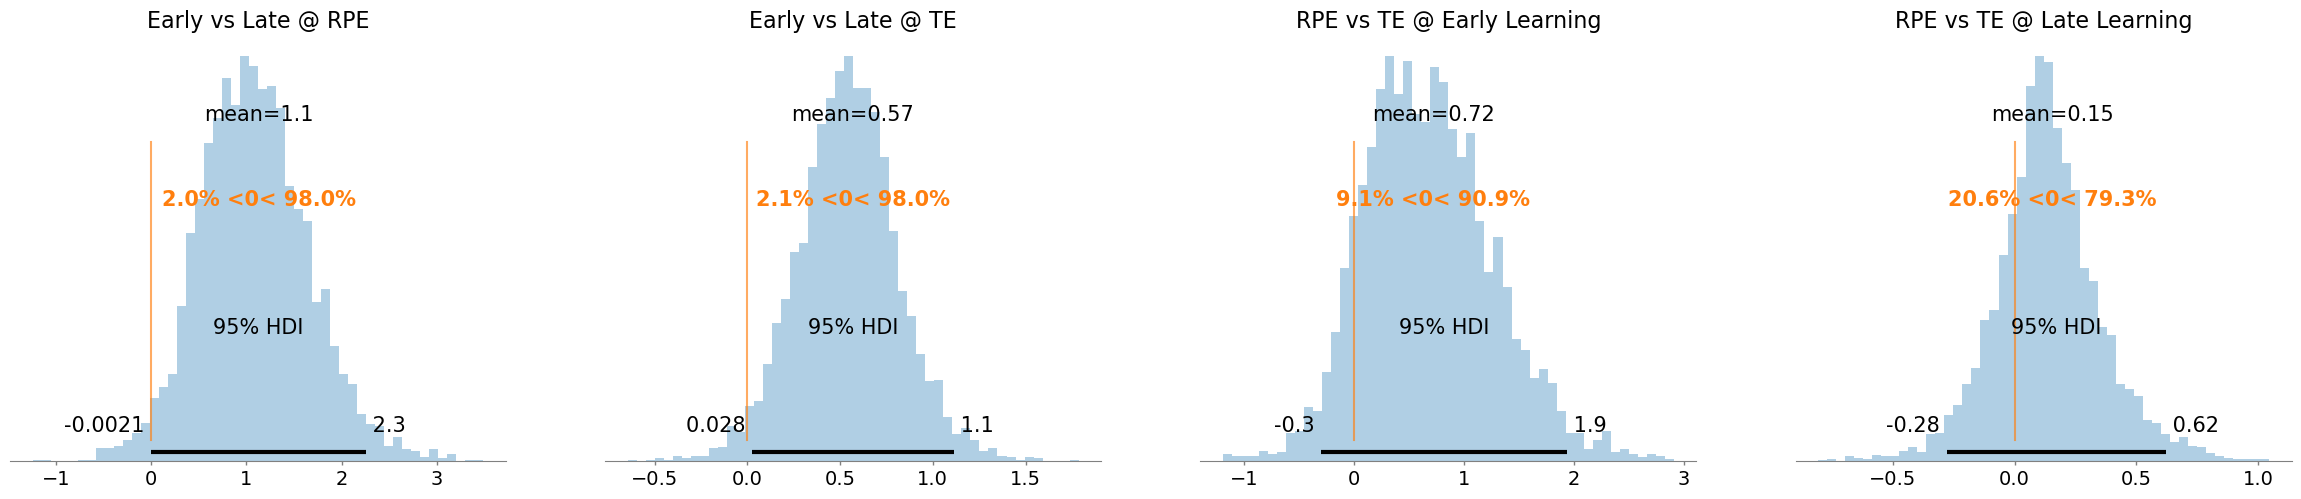

In [71]:
plot_contrasts(post_var_e2, round_to=2)